## Summary

Created: 10/20/2017 (cloned from part2_analysis_wasp21)

Last edit: 10/20

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
#import multiprocessing

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

In [4]:
import getpass
from tqdm import tqdm

data_dir = '.'
file_list=glob.glob(data_dir+'/*band.csv')
file_list.sort()
len(file_list)

3

## import lc

In [5]:
data={}
bands='g,r,z'.split(',')

for i,(f,b) in enumerate(zip(file_list,bands)):
    df=pd.read_csv(os.path.join(data_dir,f), delimiter=',', parse_dates=True)
    #df.columns='GJD,GJD-2450000,flux,err,airmass,sky,dx,dy'.split(',')
    #df = df.set_index('BJD(TDB)-2450000')
    #df = df.set_index('GJD-2450000')
    df = df.set_index('GJD')
    data[b]=df

In [6]:
data[b].head()

GJD-2450000      flux       err  airmass    sky     dx      dy
GJD                                                                         
2.457873e+06  7873.125249  1.002693  0.001688   1.0168  204.5  4.071  18.302
2.457873e+06  7873.125874  1.005096  0.001696   1.0171  204.5  3.827  18.789
2.457873e+06  7873.126499  1.003830  0.001694   1.0174  205.3  3.788  19.184
2.457873e+06  7873.127135  1.004984  0.001695   1.0177  206.3  3.310  19.632
2.457873e+06  7873.127760  1.001326  0.001692   1.0180  206.6  3.489  20.148

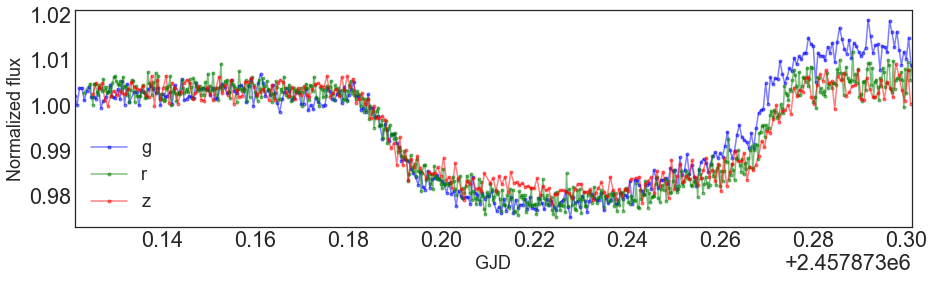

In [7]:
colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for (b,c) in zip(sorted(bands),colors):
    df = data[b]
    df.flux.plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    ax.set_ylabel('Normalized flux')
pl.legend()

In [8]:
fig.savefig('figs/raw.png')

## building the model

* See [exoplanet.org](http://exoplanets.org/detail/HAT-P-12_b) for published transit parameters

In [9]:
from uncertainties import ufloat 

P   = ufloat(3.2130598,2.1e-6)
Rp  = ufloat(0.959,0.029)
#tc  = ufloat(2454400.19885, 0.0002) 
t14 = ufloat(0.09740,0.0006) 
b   = ufloat(0.211,0.07)     
a_s = ufloat(11.80,0.31)   
k   = ufloat(np.sqrt(0.01977),np.sqrt(0.000183)) 
rhop= ufloat(0.295,0.025)
inc = ufloat(89.00,0.4)

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [10]:
_P   = 3.2130598
#_tc  = 245778e6+8.01
_t14 = 0.09740
_b   = 0.211
_a_s = 11.80
_k   = np.sqrt(0.01977)
_inc = np.deg2rad(89.00)

def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

a_s_=scaled_a(_P, _t14, _k, i=_inc, impact_param=_b)
a_s_

11.789821867071863

In [11]:
inc_ = np.arccos(_b/a_s_)
np.rad2deg(inc_)

88.974534554473834

In [12]:
from pytransit import MandelAgol
MA = MandelAgol()

def q_to_u(q1, q2):
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    MA = MandelAgol()
    k,tc,a,b,q1,q2 = theta[:6]
    inc   = np.arccos(b/a)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

In [13]:
tc_0  = 2.457873e6+0.23
q1_0, q2_0 = 0.4, 0.4

theta_true= [_k,tc_0,_a_s, _b, q1_0, q2_0]

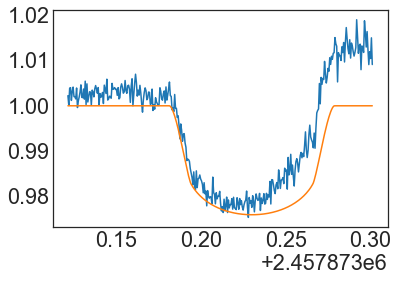

In [14]:
b='g'
f=data[b].flux
t=data[b].index

m=model_q(theta_true, t, _P)

pl.plot(data[b].index,f)
pl.plot(t,m)

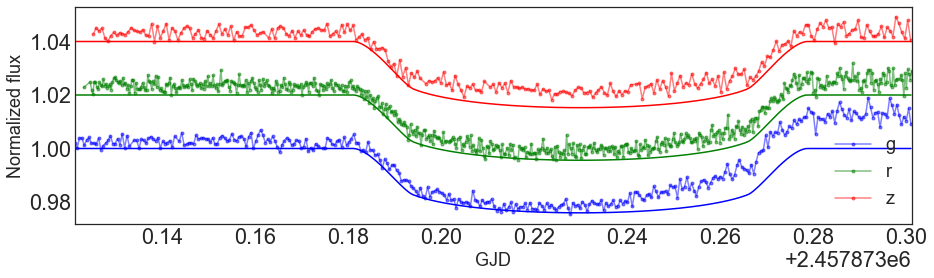

In [15]:
theta_vec = []

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for i,(b,c) in enumerate(zip(sorted(bands),colors)):
    df = data[b]
    df.flux.apply(lambda x: x+0.02*i).plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    #compute model
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    m=model_q(theta, t, _P)
    ax.plot(t,m+0.02*i,color=c)
    ax.set_ylabel('Normalized flux')
    theta_vec.append(theta)
pl.legend()

In [16]:
import scipy.optimize as op

def obj(theta, t, f, p):
    '''
    objective function is ordinary least squares
    c.f. chi-quared which includes point-wise sigma
    '''
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

In [17]:
ts = [data[b].index for b in sorted(bands)]
fluxes = [data[b]['flux'] for b in bands]

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [18]:
import scipy.optimize as op

def obj(theta, t, f, p):
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

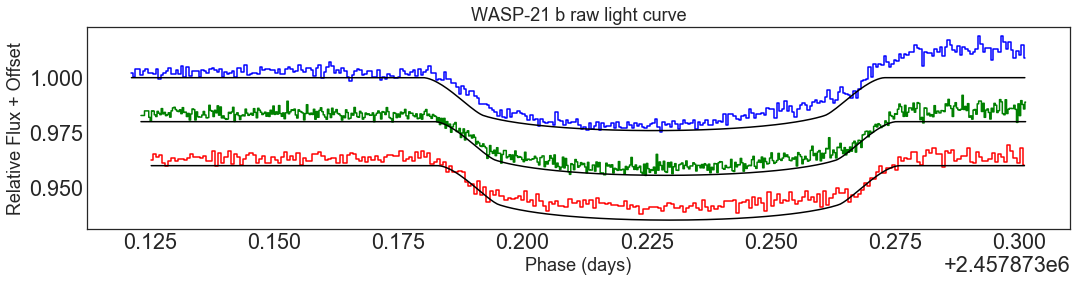

In [19]:
fontsize=18

ts,fluxes=[],[]
airmasses,uncs,dxs,dys=[],[],[],[]

colors='b,g,r'.split(',')

fig, axs = pl.subplots(1,1, figsize=(15,4), sharey=True)
for i,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)    
    f=d['flux']
    t=f.index
    
    ts.append(t)
    fluxes.append(f)
    
    axs.plot(t,f-0.02*i, drawstyle='steps-mid', c=colors[i])
    res = op.minimize(obj, theta_vec[i], args=(t, f, _P), method='nelder-mead')
    model = model_q(res.x, t, _P)
    axs.plot(t, model-0.02*i, 'k-');
    
    fig.tight_layout()

    #sys mod params
    airmasses.append(d['airmass'])
    uncs.append(d['err'].values)
    #peak_fluxes.append(d['peak'].values)
    #fwhms.append(d['fwhm'].values)
    dxs.append(d['dx'].values)
    dys.append(d['dy'].values)
    
axs.set_title('WASP-21 b raw light curve',fontsize=fontsize)
axs.set_ylabel('Relative Flux + Offset',fontsize=fontsize)
axs.set_xlabel('Phase (days)',fontsize=fontsize)

In [20]:
#systematics model (time-dependent)
def model_s(theta, aux_vec, t):
    airmass, xcenter, ycenter = aux_vec
    #functional form of systematics model
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[airmass, xcenter, ycenter, offset, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, aux_vec, ret_mod=False, ret_sys=False, ret_full = False):
    #airmass, xcenter, ycenter = aux_vec
    ls = theta[6]
    m = model_q(theta[:6], t, p)
    s = model_s(theta[7:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

--g--
NLL before: -1481.6853992233953
NLL after: -1533.4009650054857
residual: std=0.0039, rms=0.0068
--r--
NLL before: -2748.8809164331806
NLL after: -2857.1218436877652
residual: std=0.0020, rms=0.0048
--z--
NLL before: -1239.7568530720469
NLL after: -1293.743248704906
residual: std=0.0023, rms=0.0036


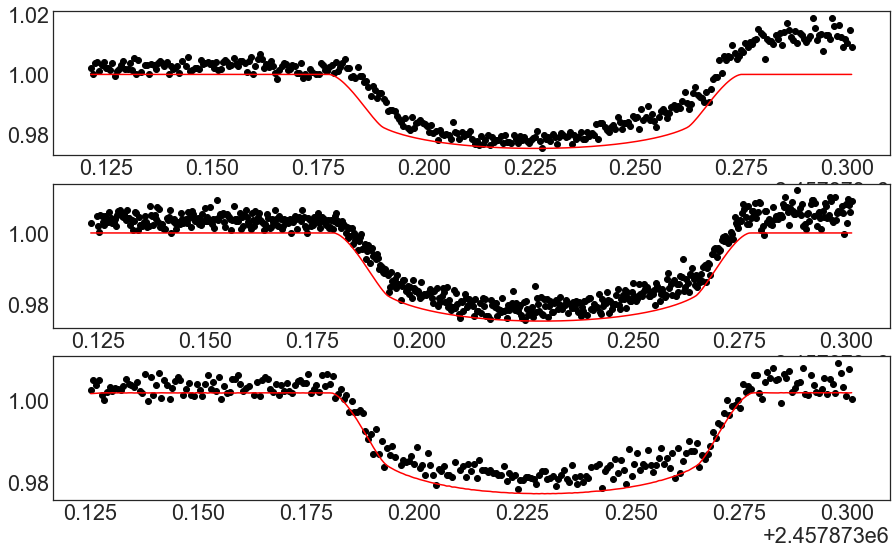

In [21]:
#systematics parameters
k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [0]*10
#log flux uncertainty
k_list= [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]
nparams=5
ip = 0 #impact param, b
#parameters vector: 6 free, 7 input

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

for n,b in enumerate(sorted(bands)):
    d=data[b]
    #dropna
    #d=d.dropna(axis=0)
    #remove outliers
    #d=d[np.abs(d-d.mean())<=(3*d.std())]

    f=d['flux']
    t=f.index

    #sys mod params
    airmass = d['airmass'].values
    err=d['err'].values
    #peak_flux=d['peak(ADU)'].values
    #fwhm = d['fwhm(pix)'].values
    dx = d['dx'].values
    dy = d['dy'].values
    print('--{}--'.format(b))
    
    #parameters vector: 6 free, 3 input
    ls = np.log(np.nanstd(f))
    
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta_sys = np.concatenate((theta, [ls], k_list[:nparams]))
    
    aux_vec = (airmass, dx, dy)
    print ("NLL before: {}".format(nll(theta_sys, t, f, _P, aux_vec)))
    result = op.minimize(nll, theta_sys,    args=(t, f, _P, aux_vec), 
                         method='nelder-mead')
    print ("NLL after: {}".format(nll(result.x,   t, f, _P, aux_vec)))

    f_pred = loglike(result.x, t, f, _P, aux_vec, ret_full=True)
    mod    = loglike(result.x, t, f, _P, aux_vec, ret_mod=True)
    sys    = loglike(result.x, t, f, _P, aux_vec, ret_sys=True)
    resid=f-f_pred
    sigma=np.std(resid)
    rms=np.sqrt(np.mean(resid**2))
    print('residual: std={0:.4f}, rms={1:.4f}'.format(sigma, rms))
    
    ax = pl.subplot(3,1,n+1)
    ax.plot(t, f, 'ko', t, f_pred, 'r-');

In [22]:
fig.savefig('figs/model-MLE.png')

## Limb-darkening prior
```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [23]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=4650,60, 4.610,0.01, -0.290,0.05

#limbdark priors
ldp = []
for i in 'g*,r*,z*'.split(','):
    ldp.append(lb.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4)))

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

In [24]:
theta

[0.14260583202698243, 2457873.23, 11.811226632004658, 0.211, 0.4, 0.4]

In [25]:
from scipy import stats
def logprior(theta,up=None):
    k,tc,a,impact_param,q1,q2 = theta[:6]
    inc=np.arccos(impact_param/a)
    
    
    #or k from 0 up to order of max_k (Seager paper)?
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > 1 or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a   < 0 or a  > 100 or \
        tc < t[0] or tc > t[-1]:
            
        print('off limits encountered in logprior')
        return -np.inf

    lp = 0
    #u prior
    u1,u2 = q_to_u(q1,q2)
    
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    
    return lp

def logprob(theta_sys,ts,fluxes,p,airmasses,dxs,dys,up=None):
    t1,t2,t3 = ts
    f1,f2,f3 = fluxes
    airmass1,airmass2,airmass3 = airmasses
    xcen1,xcen2,xcen3 = dxs
    ycen1,ycen2,ycen3 = dys
    k1,k2,k3,tc,a1,a2,a3,impact_param,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,\
    k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta_sys
    
    theta1 = [k1,tc,a1,impact_param,q11,q21,ls1,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a2,impact_param,q12,q22,ls2,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a3,impact_param,q13,q23,ls3,k03,k13,k23,k33,k43]
    
    aux_vec1 = airmass1, xcen1, ycen1
    aux_vec2 = airmass2, xcen2, ycen2
    aux_vec3 = airmass3, xcen3, ycen3
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, f1, p, aux_vec1)
    ll += loglike(theta2, t2, f2, p, aux_vec2)
    ll += loglike(theta3, t3, f3, p, aux_vec3)
    
    if up is not None:
        lp  = logprior(theta1,up=up[0])
        lp += logprior(theta2,up=up[1])
        lp += logprior(theta3,up=up[2])
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

sanity check

In [26]:
theta_vec=[]
for i,j in enumerate(bands):
    #a.append(scaled_a(p_, t14_, k_, inc=np.pi/2))
    k_0    = _k+0.001*i
    a_s_  = scaled_a(_P, _t14, k_0, i=_inc, impact_param=_b)
    theta = [k_0,tc_0,a_s_, _b, q1_0, q2_0]
    theta.append(theta_vec)

k1,k2,k3     = [_k+0.001,_k+0.002,_k+0.002]  
q11,q12, q13 = [0.4] * 3
q21,q22, q23 = [0.4] * 3
a1,a2,a3     = [a_s_]* 3

#systematics parameters
k01, k11, k21, k31, k41 = [0] * 5
k02, k12, k22, k32, k42 = [0] * 5
k03, k13, k23, k33, k43 = [0] * 5


#log flux uncertainty
ls1,ls2,ls3 = [np.log(np.nanstd(f)) for f in fluxes]  
t1,t2,t3         = ts
f1,f2,f3         = fluxes
xcen1,xcen2,xcen3= dxs
ycen1,ycen2,ycen3= dys
airmass1,airmass2,airmass3=airmasses
#fwhm1,fwhm2,fwhm3= fwhms
#unc1,unc2,unc3   = uncs

In [27]:
theta_sys = [k1,k2,k3,tc_0,a1,a2,a3,_b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]
args = [ts,fluxes,_P,airmasses,dxs,dys]

In [28]:
#without ldp
logprob(theta_sys, *args)

5472.0299894639738

In [29]:
#with ldp
logprob(theta_sys, *args, up=ldp)

5143.1134091380945

## mcmc run

## Initial results: Parameter best estimates (including burn-in)

In [6]:
import gzip
#load gzip
loc='.'
#with gzip.GzipFile(os.path.join(loc,'best_model_1.npy.gz'), "r") as g:
with gzip.GzipFile(os.path.join(loc,'chain1.npy.gz'), "r") as g:
    chain=np.load(g)
    
with gzip.GzipFile(os.path.join(loc,'lnp1.npy.gz'), "r") as g:
    lnp=np.load(g)

In [31]:
#flatchain
nwalkers, nsteps, ndim = chain.shape
fc = chain.reshape([-1,ndim])
fc.shape

(1280000, 32)

In [7]:
#after burn-in
import gzip

with gzip.GzipFile(os.path.join(loc,'chain2.npy.gz'), "r") as g:
    chain2=np.load(g)
chain2.shape

(256, 10000, 32)

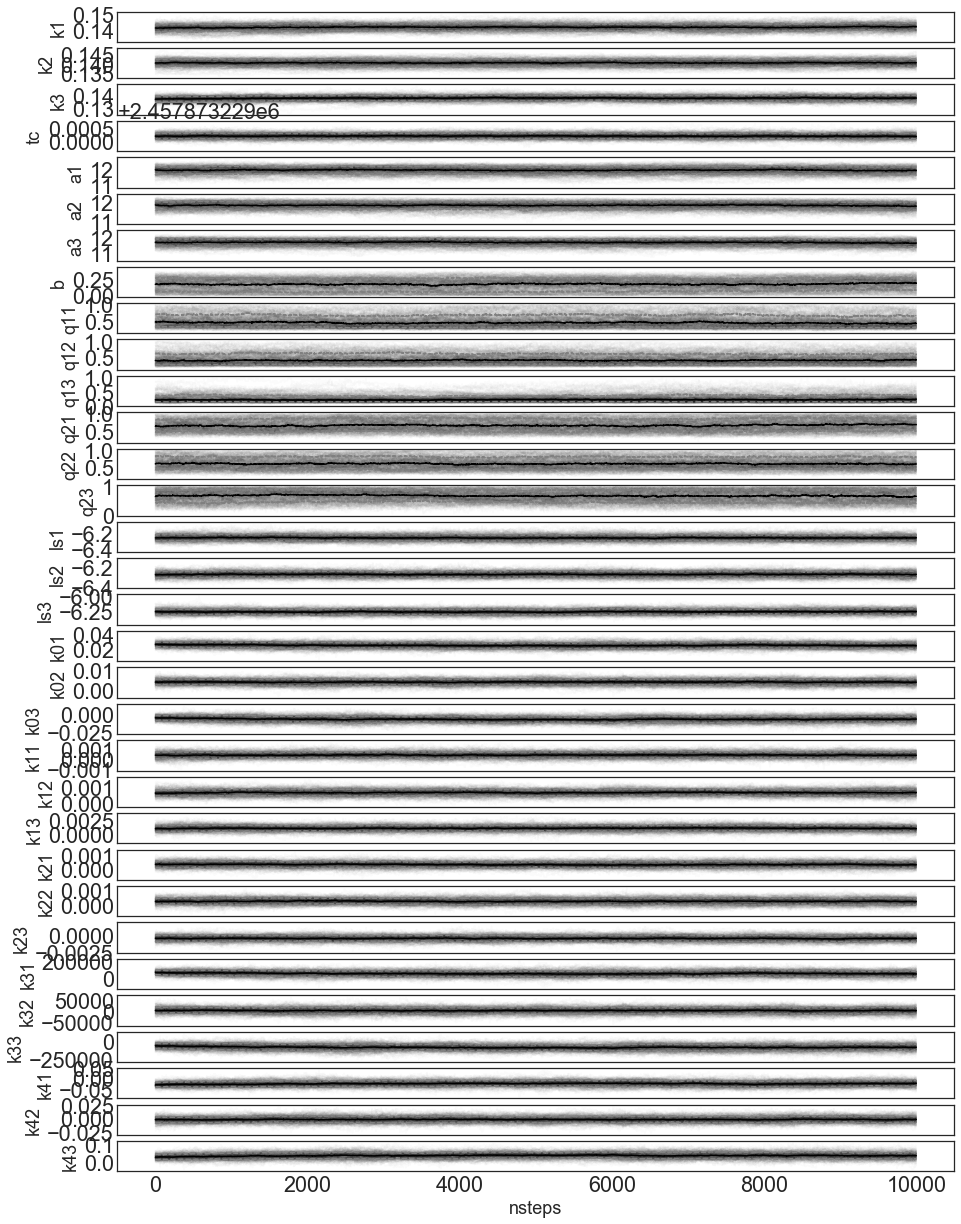

In [33]:
pl.style.use('seaborn-white')

param_names='k1,k2,k3,tc,a1,a2,a3,b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')

nwalkers, nsteps, ndim = chain2.shape
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [np.percentile(chain2[:,:,i], [50,16,84], 0) for i in range(ndim)]
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain2.T)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')

In [34]:
fig.savefig('figs/chain2.png')

In [9]:
fc = chain2.reshape([-1,chain2.shape[-1]])
fc.shape

(2560000, 32)

In [10]:
#remove burnin
burn=9000
fc = fc[256*burn:,:]
fc.shape

(256000, 32)

In [37]:
#load
import gzip
import numpy as np

with gzip.GzipFile('lnp2.npy.gz', "r") as g:
    lnp2=np.load(g)
lnp2.shape

(2560000,)

In [38]:
lnp2=lnp2[nwalkers*burn:]
lnp2.shape

(256000,)

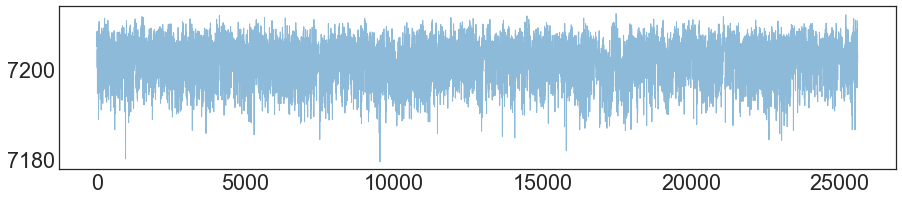

In [39]:
fig=pl.figure(figsize=(15,3))
pl.plot(lnp2[::10], lw=1, alpha=0.5)

Add 50,16,84-percentiles:

## Results

Compare the above results to previous [published results](http://exoplanet.eu/catalog/HAT-P-44_b/).

In [40]:
param_names='k1,k2,k3,tc,a1,a2,a3,b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')

#using full chain excluding burn-in
max_idx=np.argmax(lnp2)

#posterior of parameter vector
pv=fc[max_idx]

for n, i in zip(param_names, pv): 
    print('{0}: {1:.4f}'.format(n,i))

k1: 0.1420
k2: 0.1394
k3: 0.1393
tc: 2457873.2292
a1: 12.1463
a2: 11.8283
a3: 11.9017
b: 0.1243
q11: 0.3296
q12: 0.5379
q13: 0.1518
q21: 0.7516
q22: 0.4692
q23: 0.8444
ls1: -6.2527
ls2: -6.2840
ls3: -6.2733
k01: 0.0265
k02: 0.0038
k03: -0.0089
k11: 0.0005
k12: 0.0005
k13: 0.0011
k21: 0.0004
k22: 0.0002
k23: 0.0002
k31: 72602.6010
k32: 3282.9026
k33: -106191.6374
k41: -0.0295
k42: -0.0013
k43: 0.0432


In [41]:
final_theta=np.copy(pv)

In [42]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=param_names)
df.describe()

k1           k2           k3          tc           a1  \
count  256000.0000  256000.0000  256000.0000  2.5600e+05  256000.0000   
mean        0.1415       0.1409       0.1381  2.4579e+06      11.8941   
std         0.0023       0.0016       0.0021  1.0190e-04       0.2217   
min         0.1332       0.1357       0.1298  2.4579e+06      11.1279   
25%         0.1400       0.1398       0.1367  2.4579e+06      11.7409   
50%         0.1415       0.1409       0.1382  2.4579e+06      11.9067   
75%         0.1431       0.1420       0.1395  2.4579e+06      12.0579   
max         0.1494       0.1456       0.1465  2.4579e+06      12.5678   

                a2           a3           b          q11          q12  \
count  256000.0000  256000.0000  2.5600e+05  256000.0000  256000.0000   
mean       11.8095      11.6596  1.6994e-01       0.4948       0.3947   
std         0.2024       0.2239  9.1386e-02       0.1767       0.1401   
min        11.0373      10.6298  7.8060e-06       0.1726       0.1499   
25%        11.6825      11.5242  9.7312e-02       0.3600       0.2891   
50%        11.8372      11.6936  1.7118e-01       0.4573       0.3697   
75%        11.9576      11.8280  2.4318e-01       0.5936       0.4764   
max        12.3443      12.2551  4.0235e-01       0.9993       0.9938   

          ...               k13          k21          k22          k23  \
count     ...       256000.0000  256000.0000  256000.0000  256000.0000   
mean      ...            0.0011       0.0003       0.0003      -0.0004   
std       ...            0.0005       0.0002       0.0002       0.0005   
min       ...           -0.0012      -0.0007      -0.0004      -0.0023   
25%       ...            0.0007       0.0002       0.0002      -0.0007   
50%       ...            0.0011       0.0003       0.0003      -0.0004   
75%       ...            0.0015       0.0005       0.0004      -0.0001   
max       ...            0.0030       0.0012       0.0011       0.0013   

               k31          k32          k33          k41          k42  \
count  256000.0000  256000.0000  256000.0000  256000.0000  256000.0000   
mean    62014.8538    3735.1474  -90552.4188      -0.0252      -0.0015   
std     33951.0883   13527.2591   43572.2384       0.0138       0.0055   
min    -69306.6485  -56640.4435 -262507.4343      -0.0783      -0.0235   
25%     38754.0852   -5304.5938 -121020.9806      -0.0348      -0.0054   
50%     62054.5966    3920.3162  -91891.3422      -0.0252      -0.0016   
75%     85447.5707   13345.9898  -60757.1147      -0.0158       0.0022   
max    192505.1950   57852.0712  102012.6535       0.0282       0.0230   

               k43  
count  256000.0000  
mean        0.0368  
std         0.0177  
min        -0.0415  
25%         0.0247  
50%         0.0374  
75%         0.0492  
max         0.1068  

[8 rows x 32 columns]

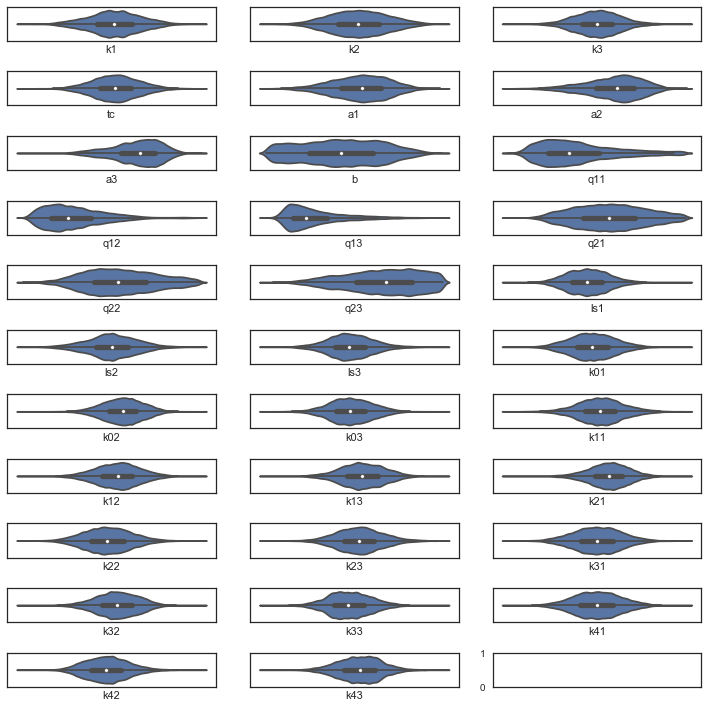

In [43]:
import seaborn as sb

with sb.axes_style('white'):
    fig, axs = pl.subplots(11,3, figsize=(10,10))
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(param_names)]
    #[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(param_names)]
    pl.setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

In [44]:
fig.savefig('figs/params_a_posteriori_distributions.png')

## BIC

In [45]:
def compute_bic(n,k,logL):
    '''
    n: number of data points
    m: number of parameters
    L: the maximized value of the likelihood function of the model
    '''
    return np.log(n)*m-2*logL

In [46]:
col1=[0,3,4,7,8,11,14,17,20,23,26,29]
col2=[1,3,5,7,9,12,15,18,21,24,27,30]
col3=[2,3,6,7,10,13,16,19,22,25,28,31]

cols=[col1,col2,col3]

m=chain2.shape[-1]

for n,(b,t,f,am,dx,dy,col) in enumerate(zip(bands,ts,fluxes,airmasses,dxs,dys,cols)):
    print(b)
    n=len(t)
    aux_vec = [am,dx,dy]
    logL=loglike([pv[i] for i in col], t, f, _P, aux_vec)
    print('loglike={}'.format(logL))
    bic=compute_bic(n,m,logL)
    print('BIC={}'.format(bic))

g
loglike=2014.4467694347327
BIC=-3841.5312373589877
r
loglike=3600.4186646302223
BIC=-6994.9318406592465
z
loglike=1597.876128023466
BIC=-3015.783695848937


## Sample the flatchain

In [47]:
#100 samples from the posterior for each band 
mod_sys={}
sys={}
mod={}

# theta1 = [k1,tc,a1,inc,u11,u21,ls1,k01,k11,k21,k31,k41]
# theta2 = [k2,tc,a2,inc,u12,u22,ls2,k02,k12,k22,k32,k42]
# theta3 = [k3,tc,a3,inc,u13,u23,ls3,k03,k13,k23,k33,k43]

col1=[0,3,4,7,8,11,14,17,20,23,26,29]
col2=[1,3,5,7,9,12,15,18,21,24,27,30]
col3=[2,3,6,7,10,13,16,19,22,25,28,31]

In [48]:
[param_names[i] for i in col1]

['k1', 'tc', 'a1', 'b', 'q11', 'q21', 'ls1', 'k01', 'k11', 'k21', 'k31', 'k41']

$$
\rm \frac{no \; detection - expected \; value}{1\sigma \; bin} = 2.4 \; \sigma
$$

$$
P(\theta|D)\propto P(\theta) \times P(D|\theta) 
$$

In [49]:
mod_best = {}
sys_best = {}
full_best = {}
nsamples=1000

#params varies per band
for b,t,f,am,xc,yc,col in zip(bands,
                             [t1,t2,t3],
                             [f1,f2,f3],
                             [airmass1,airmass2,airmass3],
                             #[unc1,unc2,unc3],
                             [xcen1,xcen2,xcen3],
                             [ycen1,ycen2,ycen3],
                            [col1,col2,col3]):
    mod_sys[b]=[]
    sys[b]=[]
    mod[b]=[]
    
    aux_vec = [am, xc, yc]
    #get 100 samples from the posterior
    for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]:
    #with replacement/ bootstrap
    #for th in [np.random.choice(fc[:,:]) for j in range(1000)]:
        '''
        th is a huge vector, get only necessary params 
        in the form of theta1,2,3 above:
        loglike(theta, t, f, p, dx, dy, dummy)
        '''
        cc=[]
        for c in col:
            cc.append(th[c])
            
        mod_sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_full=True))
        sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_sys=True))
        mod[b].append(loglike(cc, t, f, _P, aux_vec, ret_mod=True))
    #best
    vv = []
    for v in col:
            vv.append(pv[v])
    mod_best[b] = loglike(vv, t, f, _P, aux_vec, ret_mod=True)
    sys_best[b] = loglike(vv, t, f, _P, aux_vec, ret_sys=True)
    full_best[b] = loglike(vv, t, f, _P, aux_vec, ret_full=True)

check mean distribution for n samples sampled m times

### transit model

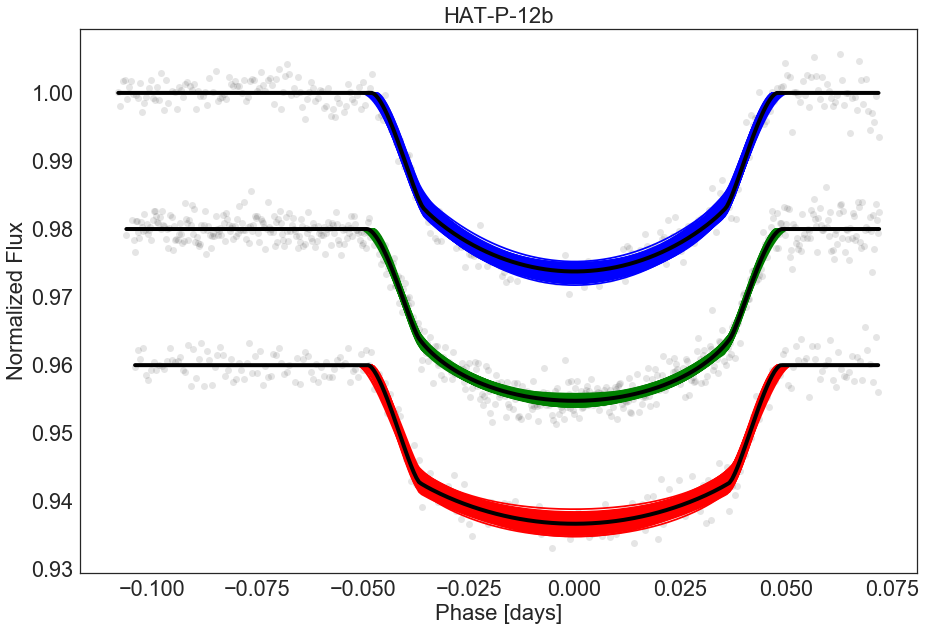

In [50]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

colors='b,g,r'.split(',')
tc_hat=pv[3]
fontsize=22
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']

fig,ax=pl.subplots(1,1,figsize=(15,10))
for n,(b,c,l) in enumerate(zip(bands,colors,labels)):
    ax.plot(ts[n]-tc_hat, fluxes[n]-sys_best[b]-0.02*n, 'ko', alpha=0.1)
    for i in mod[b]:
        ax.plot(ts[n]-tc_hat, i-0.02*n,'-', color=c, label=l)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, mod_best[b]-0.02*n, 'k-', lw=4)
    #plt.setp(ax.get_xticklabels(), visible=False)
ax.set_title('HAT-P-12b',fontsize=fontsize)
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('Phase [days]', fontsize=fontsize)
#ax.legend(labels,loc='lower right',fontsize=fontsize)

How to define 1-sigma uncertainty? 
* from sampler.flatlnprobability
* from each parameter aposteriori (i pick this)

In [51]:
pl.savefig('figs/1000_posterior_samples.png')

### systematics model

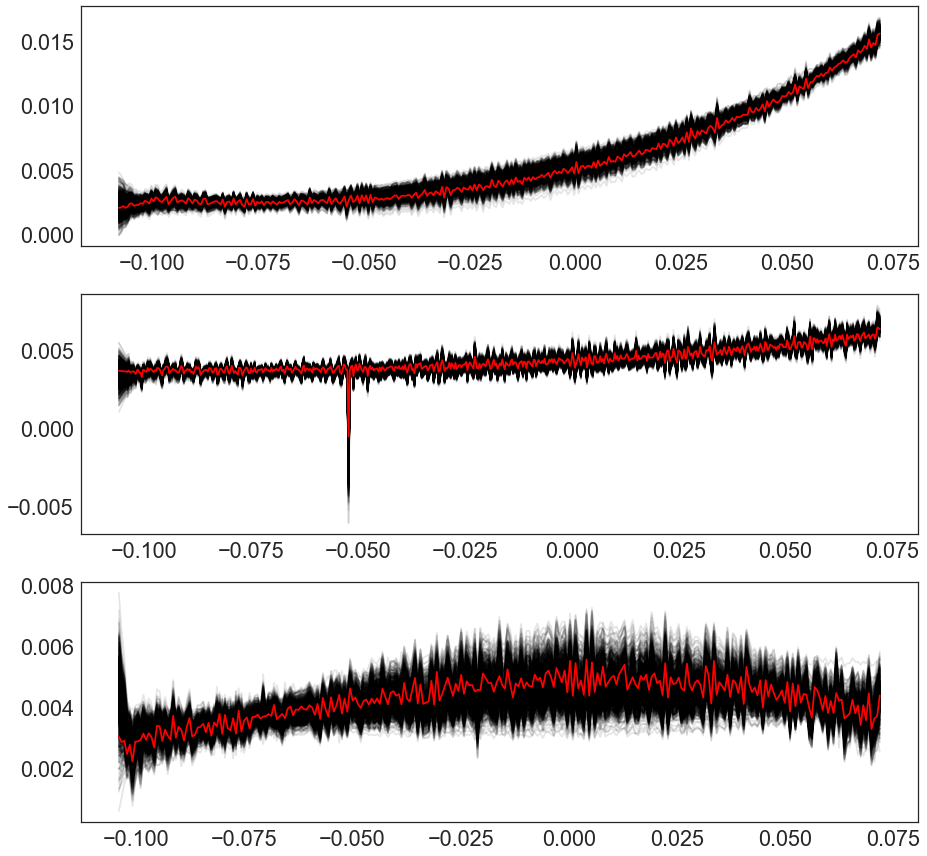

In [52]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-',alpha=0.1)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, sys_best[b], 'r-')

In [53]:
pl.savefig('figs/sys.png')

### systematics + transit

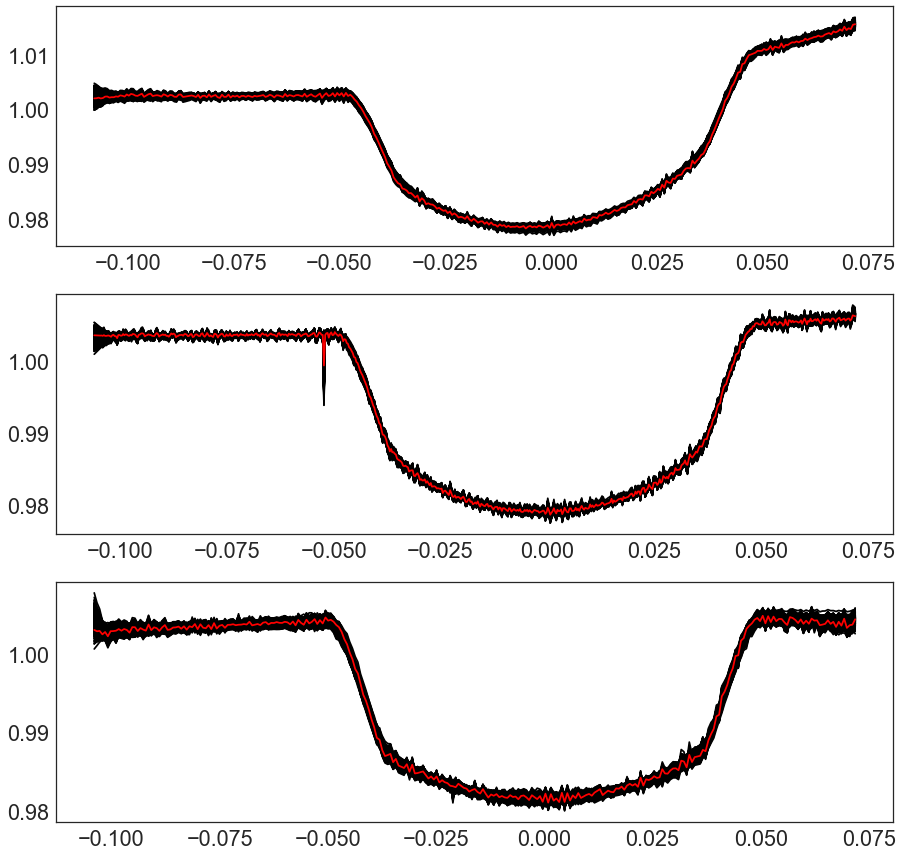

In [54]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in mod_sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-')
    #superpose best fit
    ax.plot(ts[n]-tc_hat, full_best[b], 'r-')

In [55]:
pl.savefig('figs/transit with sys.png')

## g-band

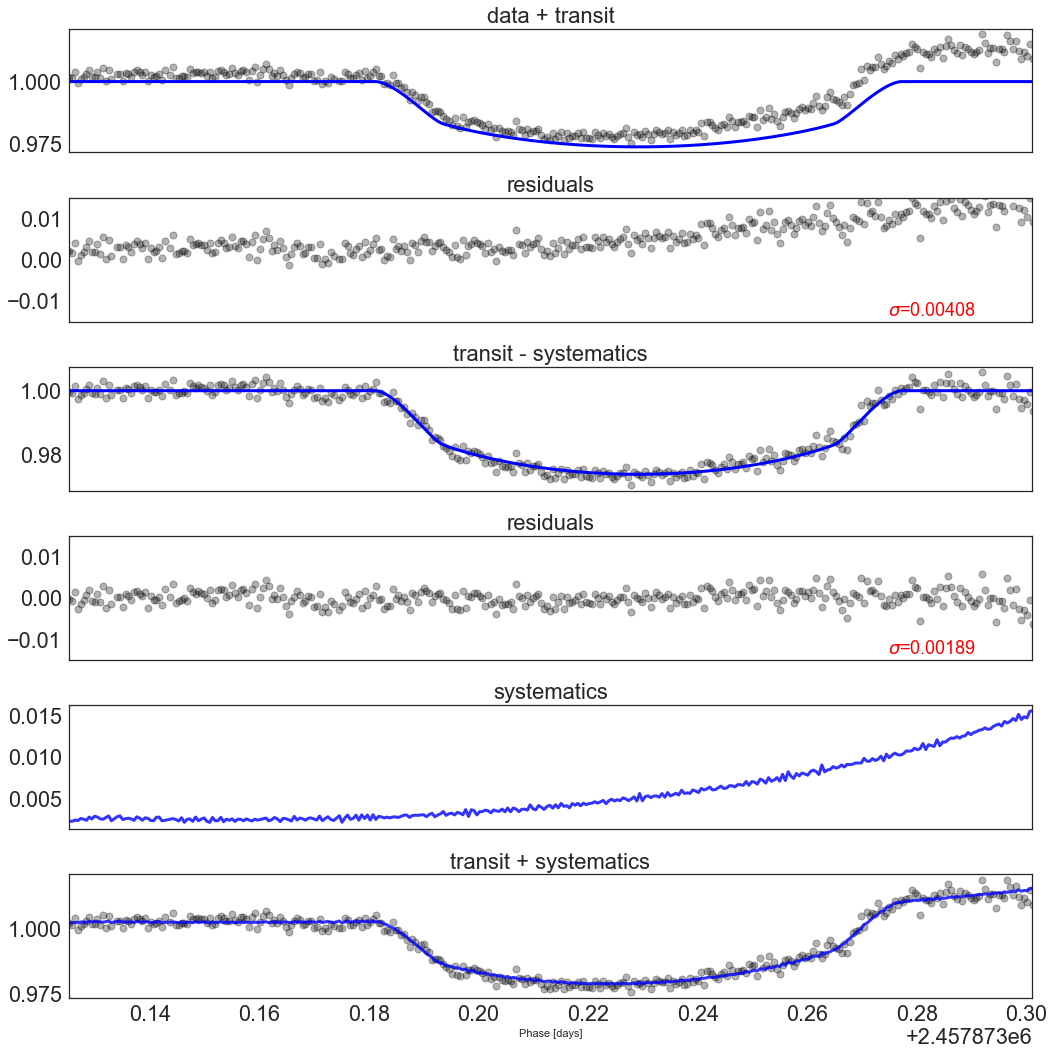

In [57]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
pl.rcParams['lines.linewidth'] = 3
n=0
b='g'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'b-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'b-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'b-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'b-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

## r-band

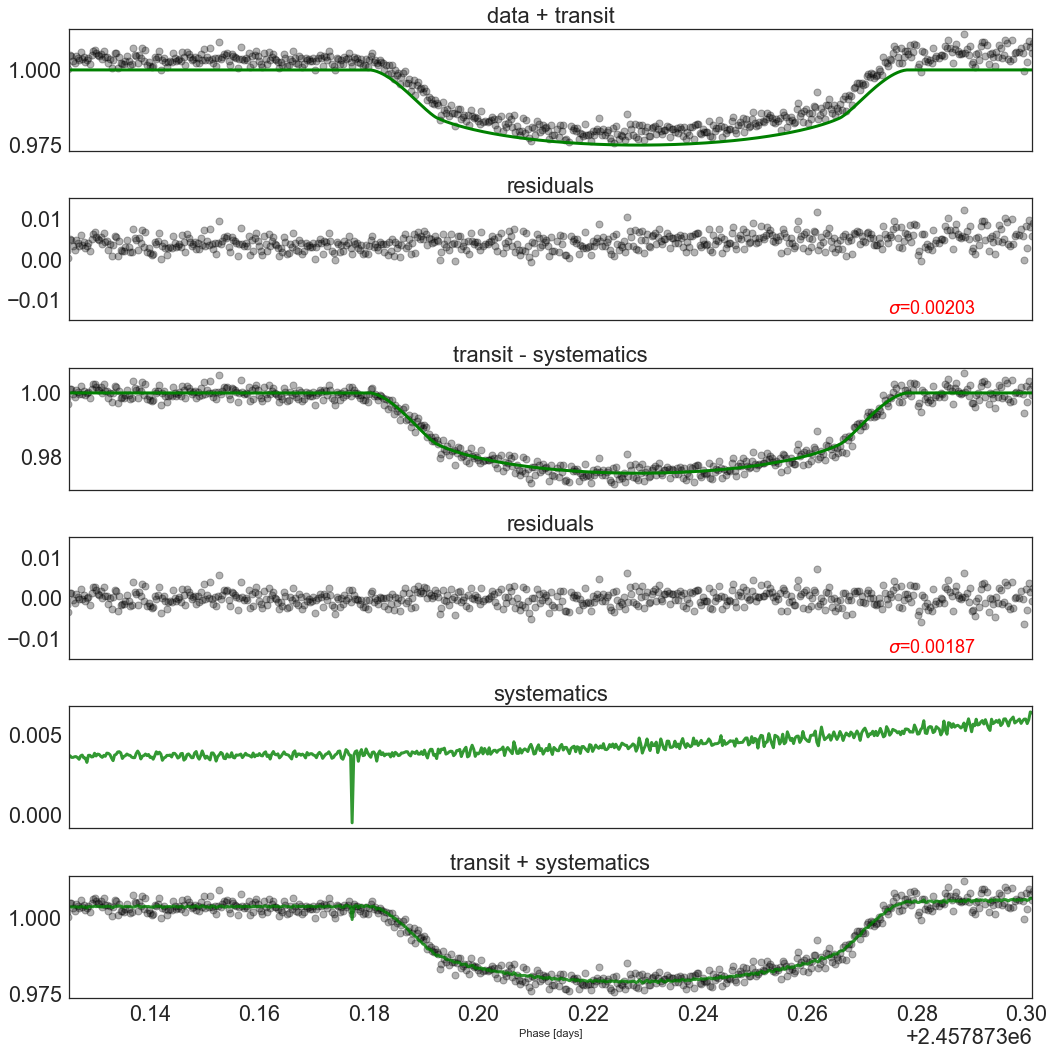

In [58]:
n=1
b='r'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'g-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'g-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'g-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'g-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [59]:
pl.savefig('figs/summary2.png')

## z-band

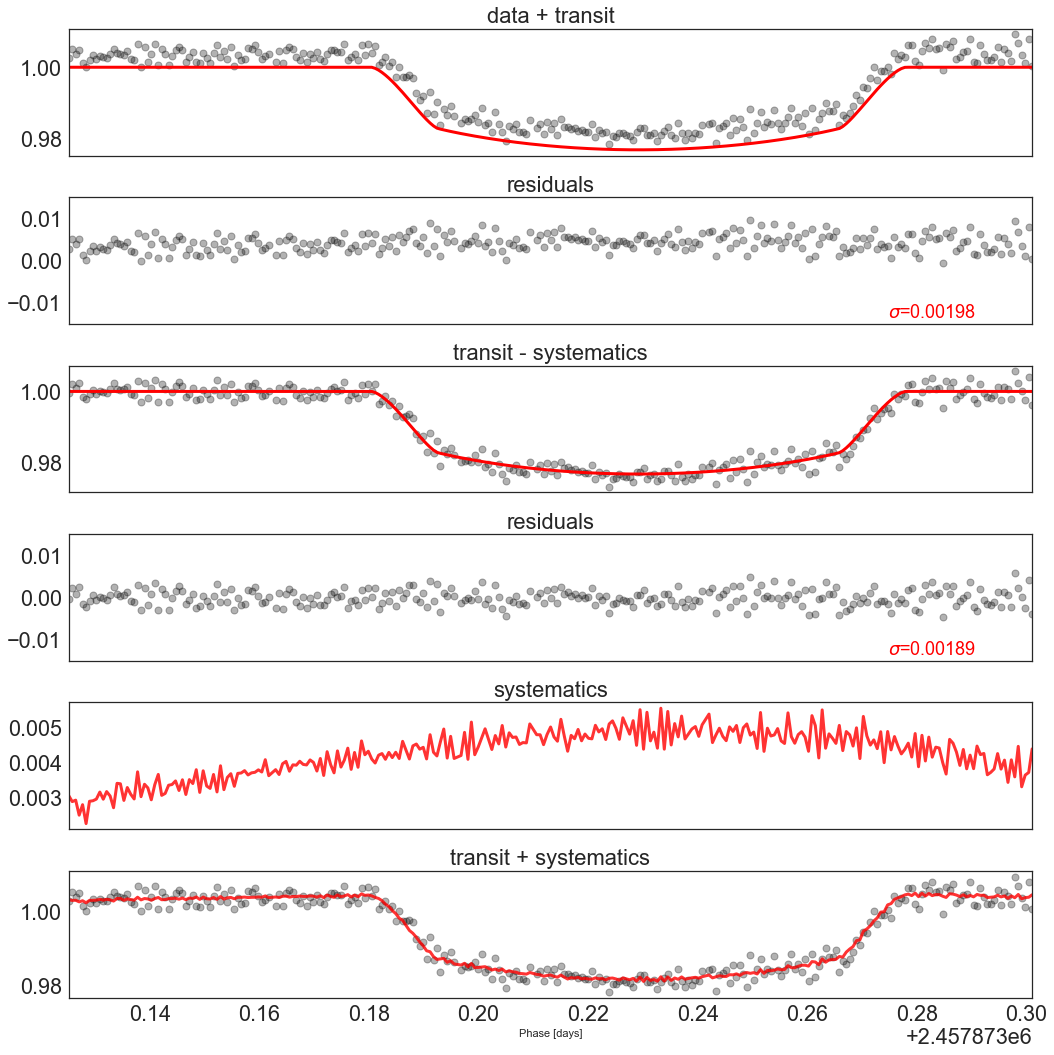

In [59]:
n=2
b='z'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'r-')
ax[0].set_title('data + transit',fontsize=fontsize)
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'r-')
ax[2].set_title('transit - systematics',fontsize=fontsize)
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(ts[n], sys_best[b], 'r-', alpha=0.8)
ax[4].set_title('systematics',fontsize=fontsize)
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'r-', alpha=0.8);
ax[5].set_title('transit + systematics',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

## rms of residuals

In [62]:
def rms(x):
    return np.sqrt(np.nanmean(x**2))

In [63]:
thinning=10
for n,b in enumerate(bands):
    print(b)
    print('rms={}'.format(rms(fluxes[n]-sys_best[b]-mod_best[b])*100))

g
rms=0.18876166834791286
r
rms=0.18749247827437818
z
rms=0.18950151858902917


## binning
* See [stackoverflow](https://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy)

The binning must be less than t14 and/or t34. Based on the best fit model on the detrended light curve, t14 is about 0.01 to 0.02 day.

## binning the residuals

Fukui-san's photometric precision achieved for HAT-P-14 (V=10):
```
g                       r                     z
RMS(10s)  = 0.10%       RMS(10s)  = 0.091%    RMS(30s) = 0.068%
RMS(5min) = 0.028%      RMS(5min) = 0.022%    RMS(5min) = 0.023%
```
$$
m_1-m_2=-2.5\log(f_1/f_2)\\
\rightarrow \frac{f_1}{f_2} = 10^{\Big(\frac{m_2-m_1}{2.5}\Big)}\\
\frac{f_1}{f_2} = 10^{\Big(\frac{13.2-10}{2.5}\Big)} = 19.9
$$
The photometric noise/ uncertainty goes with $\sqrt{\frac{f_1}{f_2}}$. Thus, the increase in the expected noise should be
$$
\sqrt{\frac{f_1}{f_2}}=4.47
$$
Currently, the rms of 0.23% for 5 minute binning, compared to Fukui-san's 0.028% is about an order of magnitude. I have to reduce this to about 5 to match the precisison achieved by Fukui-san.

In [ ]:
rms(binned.values)

## binning before model fitting

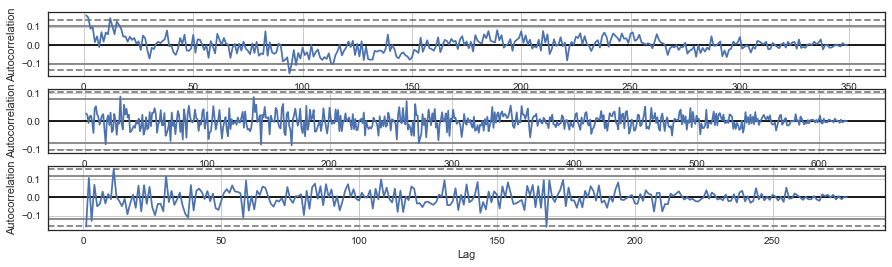

In [65]:
from pandas.plotting import autocorrelation_plot

fig = pl.figure(figsize=(15,4))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    autocorrelation_plot(fluxes[n]-sys_best[b]-mod_best[b], ax=ax)
    #autocorrelation_plot(sys_best[b]-mod_best[b], ax=ax)

In [66]:
fig.savefig('figs/autocorr.png')

correlation: u1, u2; k1, k3; i, a

In [67]:
n,b=0,'g'

d1 = {'g_flux': fluxes[n], 'g_mod': mod_best[b], 'g_sys':sys_best[b], 'g_full': full_best[b], 'g(f-sys)': fluxes[n]-sys_best[b]}
df1=pd.DataFrame(data=d1, index=ts[n])

n,b=1,'r'
d2 = {'r_flux': fluxes[n], 'r_mod': mod_best[b], 'r_sys':sys_best[b], 'r_full': full_best[b], 'r(f-sys)': fluxes[n]-sys_best[b]}
df2=pd.DataFrame(data=d2, index=ts[n])


n,b=2,'z'
d3 = {'z_flux': fluxes[n], 'z_mod': mod_best[b], 'z_sys':sys_best[b], 'z_full': full_best[b], 'z(f-sys)': fluxes[n]-sys_best[b]}
df3=pd.DataFrame(data=d3, index=ts[n])

frames = [df1, df2, df3]

final_df = pd.concat(frames)
final_df.tail()

g(f-sys)  g_flux  g_full  g_mod  g_sys  r(f-sys)  r_flux  r_full  \
GJD                                                                            
2.4579e+06       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   
2.4579e+06       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   
2.4579e+06       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   
2.4579e+06       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   
2.4579e+06       NaN     NaN     NaN    NaN    NaN       NaN     NaN     NaN   

            r_mod  r_sys  z(f-sys)  z_flux  z_full  z_mod   z_sys  
GJD                                                                
2.4579e+06    NaN    NaN    1.0023  1.0068  1.0045    1.0  0.0045  
2.4579e+06    NaN    NaN    1.0002  1.0034  1.0033    1.0  0.0033  
2.4579e+06    NaN    NaN    0.9975  1.0011  1.0036    1.0  0.0036  
2.4579e+06    NaN    NaN    1.0042  1.0079  1.0037    1.0  0.0037  
2.4579e+06    NaN    NaN    0.9961  1.0005  1.0044    1.0  0.0044

## Save

In [68]:
final_df.to_csv('after_mcmc_hatp12b.csv')

In [69]:
np.save('theta_post.csv',final_theta)

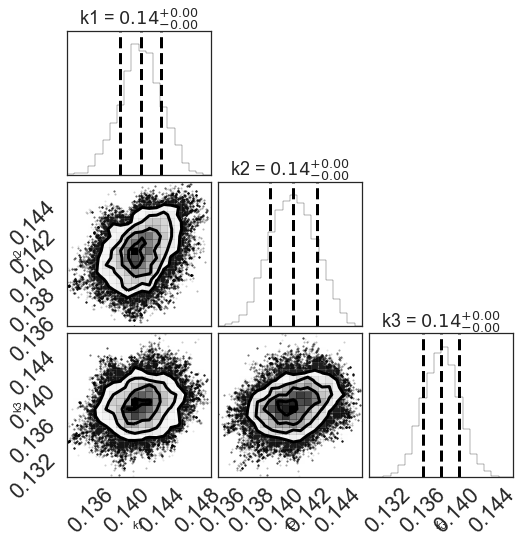

In [61]:
import corner


fig = corner.corner(fc[:,:3], labels=param_names[:3], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [62]:
fig.savefig('figs/joint_k.png')

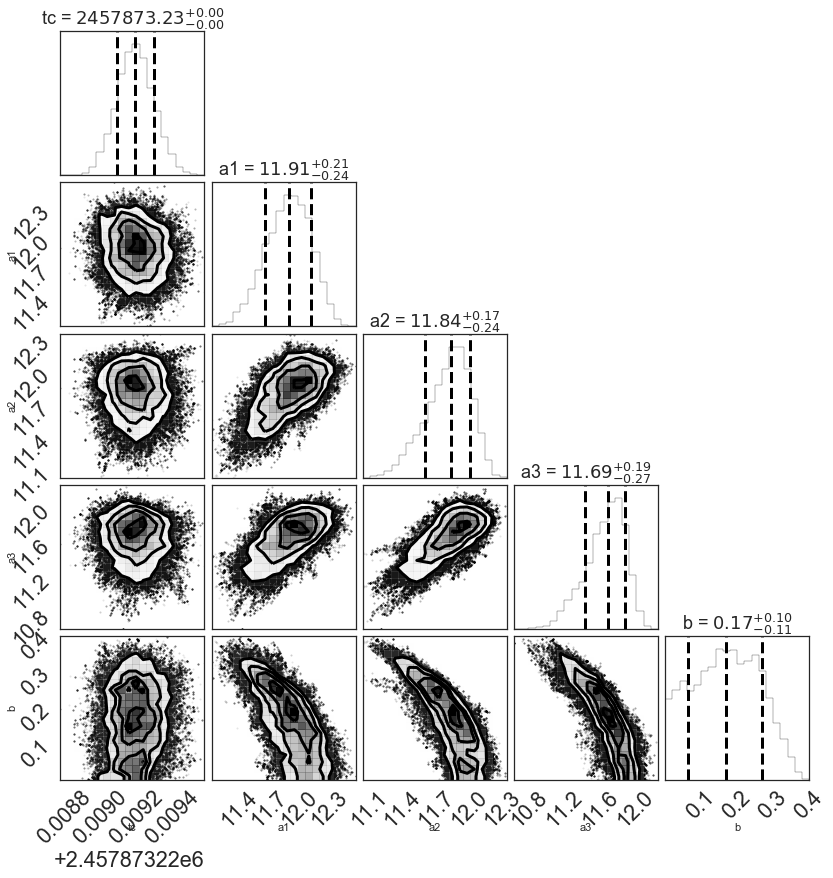

In [63]:
fig = corner.corner(fc[:,3:8], labels=param_names[3:8], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [64]:
fig.savefig('figs/joint_tc_a_b.png')

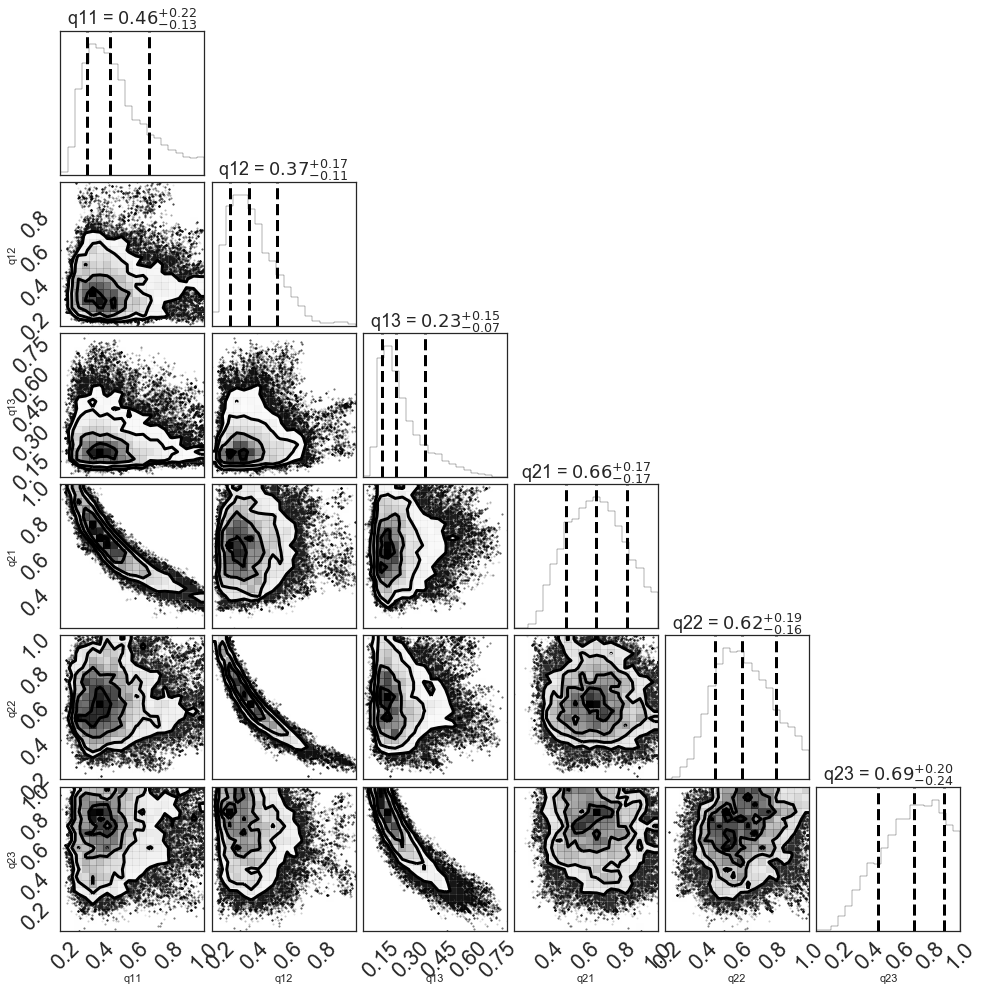

In [65]:
fig = corner.corner(fc[:,8:14], labels=param_names[8:14], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [66]:
fig.savefig('figs/q.png')

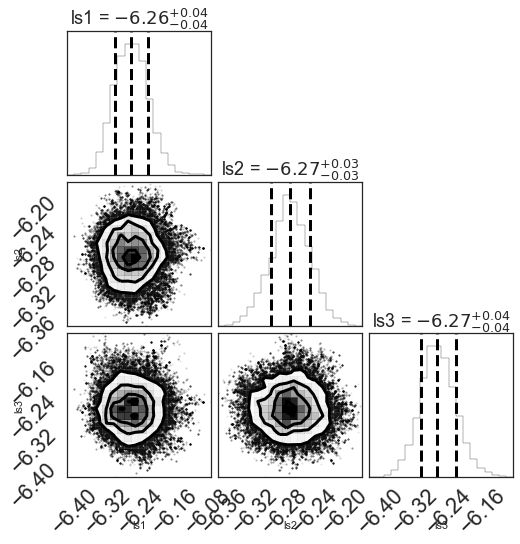

In [67]:
fig = corner.corner(fc[:,14:17], labels=param_names[14:17], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [68]:
fig.savefig('figs/logsig.png')

In [69]:
fig = corner.corner(fc[:,17:], labels=param_names[17:], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [70]:
fig.savefig('figs/joint_coeffs.png')

## even sampling of time (index)

Add evenly sampled time to compensate for sparse data (resulting to edgy/not smooth model fits especially in limb-darkening areas.

### Reevaluate model using new evenly-sampled time

## best fit with uncertainties: credible intervals

In [83]:
post=[]
for i,(j,p) in enumerate(zip(pv,param_names)):
    fc_sample=fc[np.random.randint(0, fc.shape[0], size=1000)]
    sig_minus,mean,sig_plus=np.percentile(fc_sample[:,i], [16,50,84], axis=0)
    vals='{0}={1:.4f}\t- {2:.4f} \t+ {2:.4f}'.format(p,j,sig_minus,sig_plus)
    post.append(vals)
    print(vals)
    #print(mean)
np.save('post_with_unc_hapt12b.csv',post)

k1=0.1420	- 0.1393 	+ 0.1393
k2=0.1394	- 0.1392 	+ 0.1392
k3=0.1393	- 0.1360 	+ 0.1360
tc=2457873.2292	- 2457873.2291 	+ 2457873.2291
a1=12.1463	- 11.6665 	+ 11.6665
a2=11.8283	- 11.6059 	+ 11.6059
a3=11.9017	- 11.4326 	+ 11.4326
inc=0.1243	- 0.0672 	+ 0.0672
u11=0.3296	- 0.3249 	+ 0.3249
u12=0.5379	- 0.2509 	+ 0.2509
u13=0.1518	- 0.1597 	+ 0.1597
u21=0.7516	- 0.4865 	+ 0.4865
u22=0.4692	- 0.4710 	+ 0.4710
u23=0.8444	- 0.4566 	+ 0.4566
ls1=-6.2527	- -6.3045 	+ -6.3045
ls2=-6.2840	- -6.2964 	+ -6.2964
ls3=-6.2733	- -6.3056 	+ -6.3056
k01=0.0265	- 0.0215 	+ 0.0215
k02=0.0038	- 0.0027 	+ 0.0027
k03=-0.0089	- -0.0114 	+ -0.0114
k11=0.0005	- 0.0001 	+ 0.0001
k12=0.0005	- 0.0005 	+ 0.0005
k13=0.0011	- 0.0006 	+ 0.0006
k21=0.0004	- 0.0001 	+ 0.0001
k22=0.0002	- 0.0001 	+ 0.0001
k23=0.0002	- -0.0009 	+ -0.0009
k31=72602.6010	- 29939.2261 	+ 29939.2261
k32=3282.9026	- -9118.3163 	+ -9118.3163
k33=-106191.6374	- -129796.2432 	+ -129796.2432
k41=-0.0295	- -0.0395 	+ -0.0395
k42=-0.0013	- -0.0070 

# Import mcmc results

In [84]:
pv[3]

2457873.2291975981

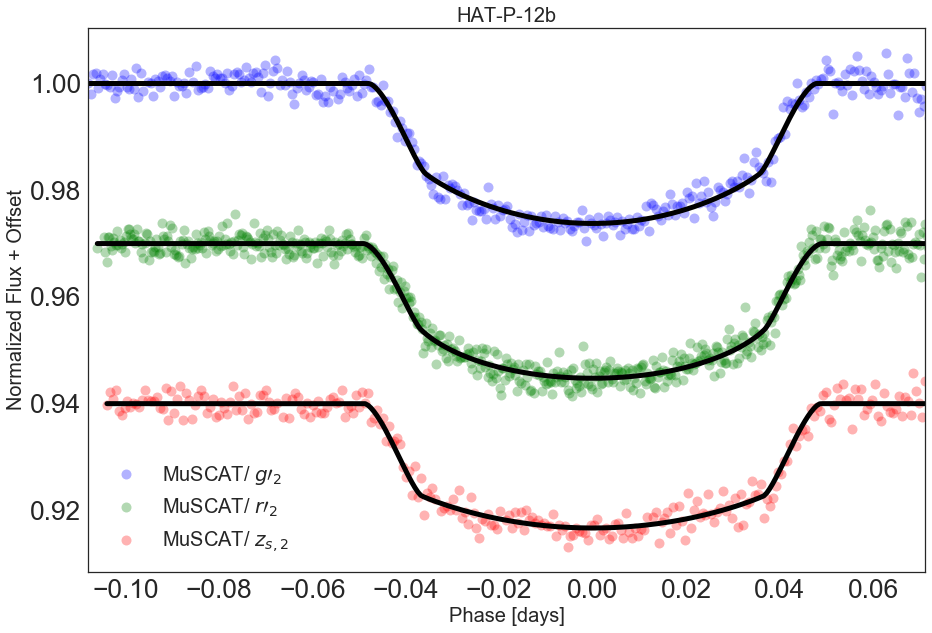

In [71]:
import matplotlib 
# # #matplotlib.rcParams.keys()
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 5})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=20

final_df=pd.read_csv('after_mcmc_hatp12b.csv', parse_dates=True, index_col=0)

tc=pv[3]

final_df.index=final_df.index-tc
fig,ax=pl.subplots(1,1,figsize=(15,10))
cols='g(f-sys),r(f-sys),z(f-sys)'.split(',')
colors=['b','g','r']
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']
clipped = 1
offset=0.03
for i,(col,c,l) in enumerate(zip(cols,colors,labels)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(
                marker='.', ms=20,
                alpha=0.3, linestyle='', linewidth=100,color=c, ax=ax,
                label=l)

cols2='g_mod,r_mod,z_mod'.split(',')
for i,(col,c) in enumerate(zip(cols2,colors)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(ax=ax, 
                                                    linewidth=5, color='k')
    
ax.set_xlabel('Phase [days]', fontsize=fontsize)
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
#ax.set_ylim(0.8,1)
ax.set_title('HAT-P-12b', fontsize=fontsize)
ax.legend(labels,loc='lower left', fontsize=fontsize)

In [72]:
fig.savefig('figs/grz.png')

## Best fit models and (binned) residuals
* binning3 function is not implemented because of NaNs; df.resample is better because it takes into account the actual time and not only the separation between data points (e.g. two consecutive data points might be NaN and it can be problematic after binning). 
* See `width` to check binning width in min

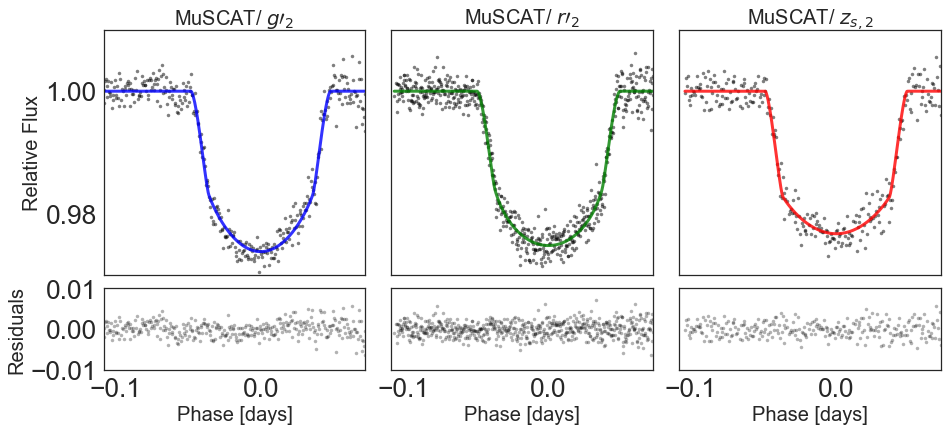

In [73]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 3})
from scipy import stats

final_df=pd.read_csv('after_mcmc_hatp12b.csv', parse_dates=True, index_col=0)
#final_df = df.set_index(pd.to_datetime(df.index, unit='D', origin=offset))

from matplotlib import gridspec

fig = pl.figure(figsize=(15,8))

gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1, 1, 1],
                       height_ratios=[3, 1, 1],
                       wspace=0.1, 
                       hspace=0.1
                       )
clip=False
binn=False
clipped=20
binning='3T'
ylims= [0.97,1.01]
ylims2= [-0.01,0.01]

tc=2457873.2292264136
final_df.index=final_df.index-tc

ax1 = pl.subplot(gs[0])
if clip==True:
    final_df.iloc[:-clipped]['g(f-sys)'].plot(marker='.',alpha=0.5, 
                                            linestyle='', color='k', ax=ax1)
elif binn==True:
    final_df['g(f-sys)'].resample(binning).mean().plot(marker='.', 
                                alpha=0.1, linestyle='-', color=colors[0], ax=ax1)
else:
    final_df['g(f-sys)'].plot(marker='.', 
                                alpha=0.5, linestyle='', color='k', ax=ax1)
final_df['g_mod'].plot(linestyle='-',alpha=0.8, color=colors[0], ax=ax1)

ax1.set_ylim(ylims)
ax1.set_title(r'MuSCAT/ $g\prime_2$',fontsize=fontsize)
ax1.set_xticklabels([])
ax1.set_ylabel('Relative Flux',fontsize=fontsize)
ax1.set_xlabel('')

ax2 = pl.subplot(gs[1])

if clip==True:
    final_df.iloc[:-clipped]['r(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[1], ax=ax2)
elif binn==True:
    final_df['r(f-sys)'].resample(binning).mean().plot(
        marker='.', alpha=0.1, linestyle='-', color=colors[1], ax=ax2)
else:
    final_df['r(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax2)
final_df['r_mod'].plot(alpha=0.8, linestyle='-', color=colors[1], ax=ax2)

ax2.set_ylim(ylims)
ax2.set_title(r'MuSCAT/ $r\prime_2$',fontsize=fontsize)
#ax2.axis()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('')

ax3 = pl.subplot(gs[2])

if clip==True: #dropna, clip
    final_df.iloc[:-clipped]['z(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[2], ax=ax3)
elif binn==True: #bin
    final_df['z(f-sys)'].resample(binning).mean().plot(
        marker='.', ls='', alpha=0.1, linestyle='-', color=colors[2], ax=ax3)
else:
    final_df['z(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax3)
final_df['z_mod'].plot(linestyle='-', alpha=0.8, color=colors[2], ax=ax3)
    
ax3.set_ylim(ylims)
ax3.set_title(r'MuSCAT/ $z_{s,2}$',fontsize=fontsize)
ax3.set_xticklabels([])
ax3.set_xlabel('')
ax3.set_yticklabels([])

ax4 = pl.subplot(gs[3])
diff_g=final_df['g(f-sys)']-final_df['g_mod']
diff_g.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax4)
#diff_g.resample(binning).mean().plot(marker='.', ax=ax4)

# t_bin=binning3(ts[0],bins=n_min_binning['g'])
# res_bin=binning3(diff_g.values,bins=n_min_binning['g'])
# ax4.plot(t_bin,res_bin,'bo')
ax4.set_ylabel('Residuals',fontsize=fontsize)
ax4.set_ylim(ylims2)
#ax4.set_xticklabels([])
ax4.set_xlabel('Phase [days]',fontsize=fontsize)

ax5 = pl.subplot(gs[4])
diff_r=final_df['r(f-sys)']-final_df['r_mod']
diff_r.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax5)
#diff_r.resample(binning).mean().plot(marker='.', ax=ax5)

# t_bin=binning3(ts[1],bins=n_min_binning['r'])
# res_bin=binning3(diff_r.values,bins=n_min_binning['r'])
# ax5.plot(t_bin,res_bin,'go')
ax5.set_ylim(ylims2)
#ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.set_xlabel('Phase [days]',fontsize=fontsize)

ax6 = pl.subplot(gs[5])
diff_z=final_df['z(f-sys)']-final_df['z_mod']
diff_z.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax6)
#fit
slope, intercept, r_value, p_value, std_err = stats.linregress(diff_z.index-tc,diff_z)
y=slope*diff_z.index-tc+intercept
ax6.plot(diff_z.index,y,alpha=0.8, linestyle='-', color=colors[2])
#diff_z.resample(binning).mean().plot(marker='.', ax=ax6)

# t_bin=binning3(ts[2],bins=n_min_binning['z'])
# res_bin=binning3(diff_z.values,bins=n_min_binning['z'])
# ax6.plot(t_bin,res_bin,'bo')
ax6.set_ylim(ylims2)
#ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.set_xlabel('Phase [days]',fontsize=fontsize)

In [74]:
fig.savefig('figs/grz with rms.png')

## Comparison of k

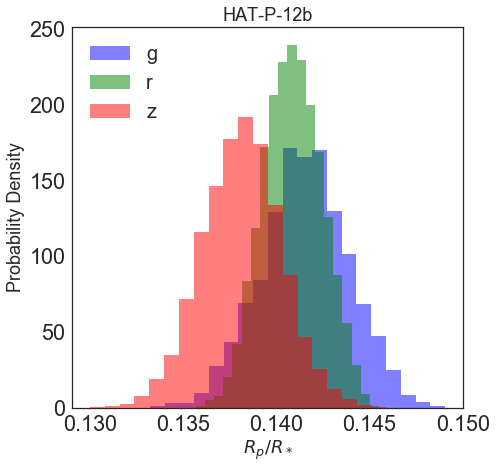

In [79]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

k_samples=[]
fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::10,n]
    ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('HAT-P-12b',fontsize=18)
pl.legend(fontsize=fontsize)

In [80]:
fig.savefig('figs/radius ratios.png')

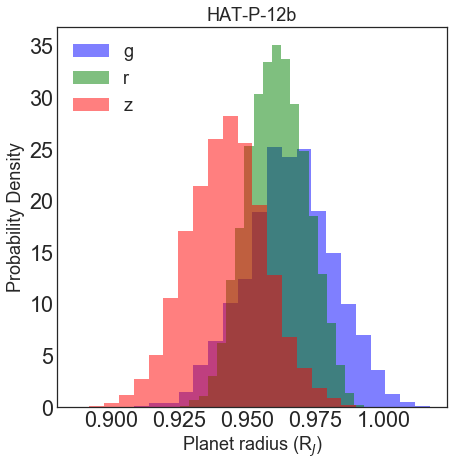

In [12]:
from astropy import units as u

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
fontsize=18
Rs=0.701 #+0.017/-0.012

k_samples=[]
fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::10,n]
    factor=Rs*u.solRad.to(u.jupiterRad)
    ax.hist(sampled*factor,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'Planet radius (R$_J$)',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('HAT-P-12b',fontsize=18)
pl.legend(fontsize=fontsize)

In [78]:
fig.savefig('figs/radius ratios Rjup.png')

In [92]:
sigma_g_minus,sigma_g_mean,sigma_g_plus= np.percentile(k_samples[0],[15.9,50,84.1])
sigma_z_minus,sigma_z_mean,sigma_z_plus= np.percentile(k_samples[2],[15.9,50,84.1])
#diff=sigma_g_mean-sigma_z_mean
diff=sigma_g_minus-sigma_z_plus

sig=np.sqrt(sigma_z_plus**2+sigma_g_minus**2)
print('sigma_rss={}'.format(sig))
print('diff={}'.format(diff))
print('sigma={}'.format(diff/sig))

sigma_rss=0.19757111008019942
diff=-0.0009925917788176364
sigma=-0.0050239722721339


In [93]:
(sigma_g_plus-sigma_z_minus)/np.mean([np.std(k_samples[0]),np.std(k_samples[2])])

3.5608197648784792

## transmission spectrum

* See also procedure of [Nikolov+2016](https://arxiv.org/pdf/1610.01186.pdf)

In [95]:
for n in range(3):
    print(np.percentile(fc[::10,n],[50,16,84]))

[ 0.14154705  0.13921775  0.14389083]
[ 0.1408626   0.1392558   0.14250104]
[ 0.13817195  0.13602015  0.14019026]


In [96]:
pv[:3]

array([ 0.14203254,  0.13938681,  0.13927453])

* blue (g'2 : 400-550nm)
* red (r'2 : 550-700nm)
* NIR (zs,2 : 820-920nm)
* rp/rs=0.1343 (i-band)

slope=-0.000003


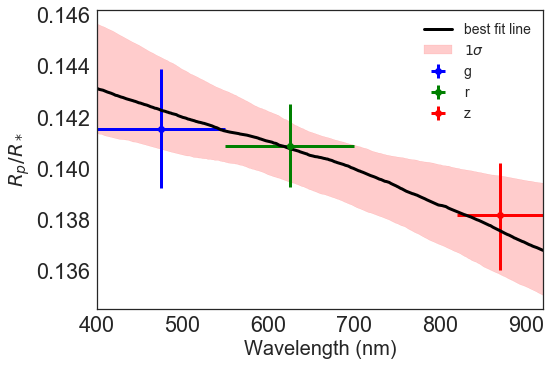

In [81]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

#bandwidths
xs1=[400,550,820]
xs2=[550,700,920]
#mean of each band
xmean=np.mean([xs1,xs2],axis=0)
ys=[]

#plot max aposteriori
fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84],axis=0)
    ys.append(y)
    
#fit a line to k1,k2,k3
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
#ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'k-')

#sample and fit slopes and intercepts from the posterior
n = 10000
x = xmean
xi = np.linspace(400, 920, 500)
ys = []
lines = []
for i in range(n):
    y = fc[i,:3]
    slope,intercept,rvalue,pvalue,stderr = lg(xmean,y)
    line = slope * xi + intercept
    lines.append(line)
    
lo, hi, mid = np.percentile(lines, [16, 84, 50], axis=0)
ax.fill_between(xi, lo, hi, color='r', alpha=0.2, label='$1\sigma$')
ax.plot(xi,mid,'k-',label='best fit line')

# plot each sample
# for slop,interc in zip(slopes,intercepts):
#     ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)

#
bands='g,r,z'.split(',')
new_axis=[]
for n,(x,c,b) in enumerate(zip(xmean,colors,bands)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c, label=b) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)
ax.set_xlim(400,920)
ax.legend(fontsize=14)

print('slope={:.6f}'.format(slope))

In [82]:
fig.savefig('figs/spectrum')

slope=-0.000017


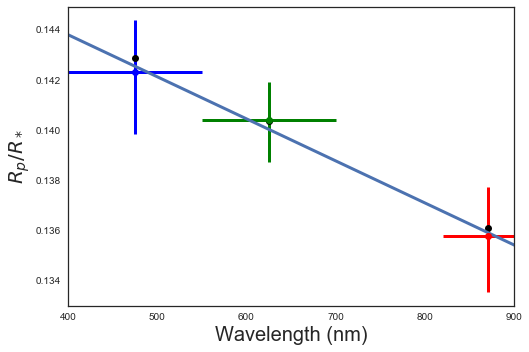

In [101]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

xs1=[400,550,820] #lower bandwidth
xs2=[550,700,920] #upper bandwidth
xmean=np.mean([xs1,xs2],axis=0)

Rs=0.701

ys=[]
new_axis=[]

colors='b,g,r'.split(',')
fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c)    
    new_axis.append(y*Rs)
    
#add i-band measurement
#ax.errorbar(763,0.1344,yerr=0.0011,fmt='o',color='orange')

#Na absorption line
#ax.axvline(x=590, ymin=0,ymax=1, linestyle='--', color='k')
#K absorption line
#ax.axvline(x=770, ymin=0,ymax=1, linestyle='--', color='k')


# ax2 = ax.twinx() # now, ax2 is responsible for "top" axis and "right" axis
# ax2.set_xticks(new_axis)
# ax2.set_xlabel('R_p (R_${Jup}$)')

ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept)
ax.set_xlim(400,900)
print('slope={:.6f}'.format(slope))

In [1]:
slopes=[]
intercepts=[]
nsamples=1000

s1=k_samples[0][np.random.randint(0, k_samples[0].shape[0], size=nsamples)]
s2=k_samples[1][np.random.randint(0, k_samples[1].shape[0], size=nsamples)]
s3=k_samples[2][np.random.randint(0, k_samples[2].shape[0], size=nsamples)]

for ss1,ss2,ss3 in zip(s1,s2,s3): 
    slope,intercept,_,_,_=lg(xmean,[ss1,ss2,ss3])
    slopes.append(slope)
    intercepts.append(intercept)

NameError: name 'k_samples' is not defined

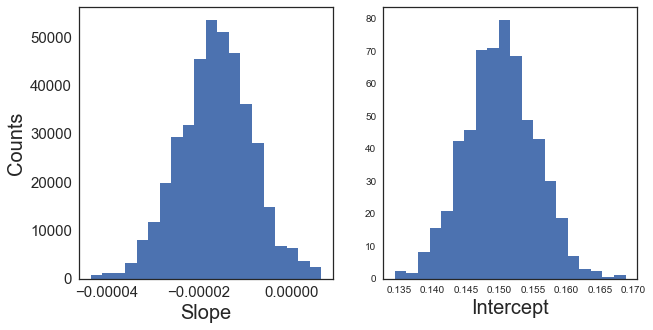

In [104]:
fig,ax=pl.subplots(1,2,figsize=(10,5))
ax[0].hist(slopes,bins=20,normed=True);
ax[0].set_ylabel('Counts',fontsize=fontsize)
ax[0].set_xlabel('Slope',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].hist(intercepts,bins=20,normed=True);
ax[1].set_xlabel('Intercept',fontsize=fontsize)

From the posterior distribution of radius ratios, we took 1000 random samples each and computed the slope of the transmission spectrum (positioned at the center of the broadband filters). The histogram of the slope is shown in Fig. X consistent with negative values with 2.3 sigma.

## significance of detection

In [105]:
x1,x2,x3=np.percentile(slopes,[50,15.9,84.1])
sig_plus=x3-x1
print((0-x1)/sig_plus)

2.1927913193


slope=-0.000017


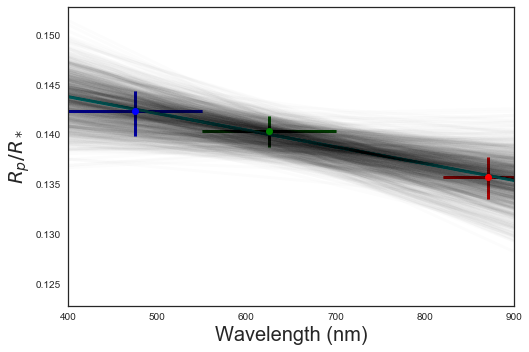

In [108]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

xs1=[400,550,820]
xs2=[550,700,920]
xmean=np.mean([xs1,xs2],axis=0)
Rs=0.979
ys=[]

fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'c-')

#slopes and intercepts from the posterior
for slop,interc in zip(slopes,intercepts):
    ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)
ax.set_xlim(400,900)

for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

print('slope={:.6f}'.format(slope))

In [109]:
(pv[0]-pv[1])*Rs

0.0024468845615379597